In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import datetime
import re
import os

# Function to retrieve grid specs

In [5]:
def return_grid_specs(path):
    
    df = pd.read_csv(path)
    col_name = df.columns[0]
    ncols_line = df.columns[0]
    nrows_line = df[col_name][0]
    xmin_line = df[col_name][1]
    ymin_line = df[col_name][2]
    size_line = df[col_name][3]

    x_n = int(ncols_line.split()[-1])
    y_n = int(nrows_line.split()[-1])
    x_min = int(float(xmin_line.split()[-1]))
    y_min = int(float(ymin_line.split()[-1]))
    cell_size = int(float(size_line.split()[-1]))

    x = np.arange(x_min, x_min + cell_size * x_n, cell_size) / 1000
    y = np.arange(y_min, y_min + cell_size * y_n, cell_size) / 1000

    return x, y

# Get data

In [6]:
# Load arrays
year = "1980" # e.g. "1980"
month = "01" # e.g. "01"
day = "01" # e.g. "01"
hour = "01" # e.g. "01"
timestamp = year + month + day + hour + "00"
time_str = year + "-" + month + "-" + day + "T" + hour + ":" + hour
wn_in_path = "/scratch/summit/erke2265/antarctic-windninja/PIG/" + timestamp + "/input/" + timestamp + "_vel.asc"
wn_out_path = "/scratch/summit/erke2265/antarctic-windninja/PIG/" + timestamp + "/output/PIG_1000m_vel.asc"
wn_processed_path = "/scratch/summit/erke2265/antarctic-windninja/PIG/processed_output/" + timestamp + "00_VW.asc"

wn_in = np.flipud(np.loadtxt(wn_in_path, skiprows=6))
wn_out = np.flipud(np.loadtxt(wn_out_path, skiprows=6))
wn_processed = np.flipud(np.loadtxt(wn_processed_path, skiprows=6))

# Return grid specs
x, y = return_grid_specs(wn_in_path)
wn_x, wn_y = return_grid_specs(wn_out_path)
wn_processed_x, wn_processed_y = return_grid_specs(wn_processed_path)

# Find max min
# maxima = np.maximum(wn_in.max(), wn_out.max())
# minima = np.minimum(wn_in.min(), wn_out.min())
maxima = wn_processed.max()
minima = wn_processed.min()
print("Maxima = " + str(maxima))
print("Minima = " + str(minima))

Maxima = 6.230000019073486
Minima = 3.2200000286102295


# MERRA-2

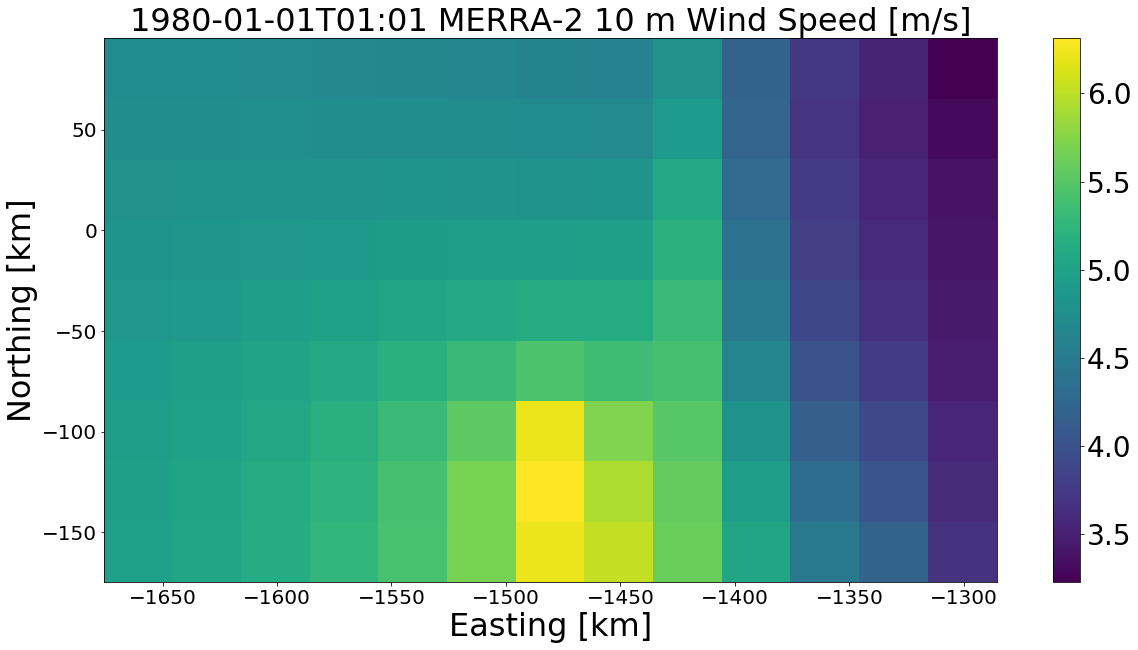

In [7]:
plt.figure(figsize=(20, 10))
# plt.pcolor(x, y, wn_in, vmin=minima, vmax=maxima)
plt.pcolor(x, y, wn_in)
cb = plt.colorbar()
# plt.xlim([wn_x.min(), wn_x.max()])
# plt.ylim([wn_y.min(), wn_y.max()])
cb.ax.tick_params(labelsize=28)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Easting [km]", fontsize=32)
plt.ylabel("Northing [km]", fontsize=32)
plt.title(time_str + " MERRA-2 10 m Wind Speed [m/s]", fontsize=32)
plt.savefig("figures/M2_wind_speed.pdf", dpi=100)
plt.savefig("figures/M2_wind_speed.png", dpi=100)

# WindNinja output

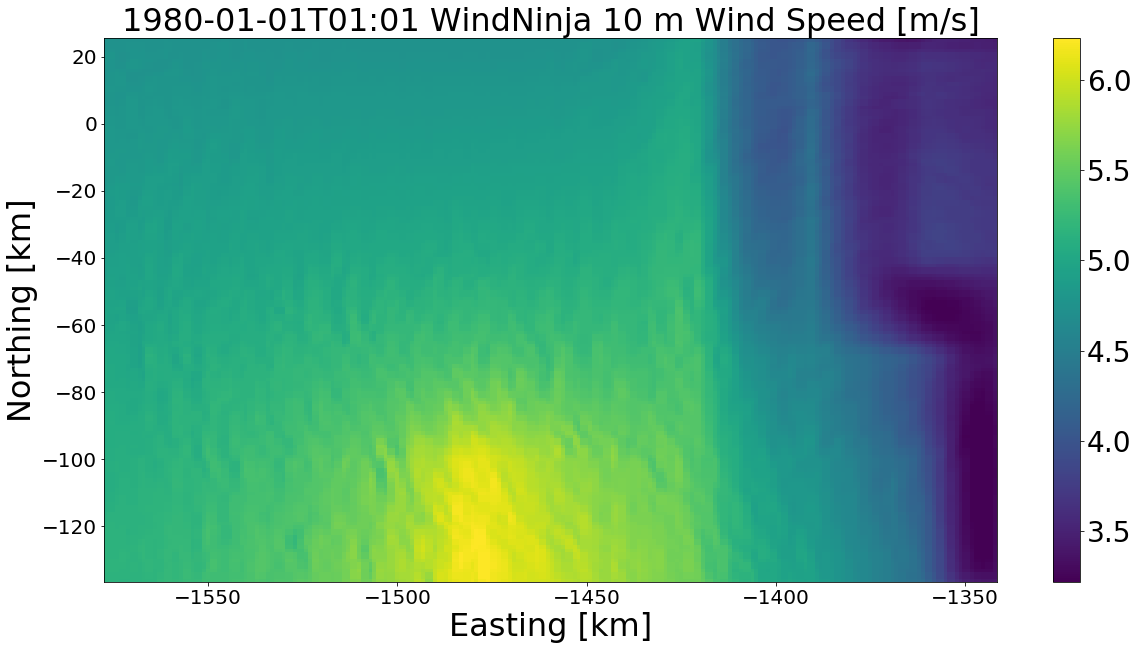

In [8]:
plt.figure(figsize=(20, 10))
plt.pcolor(wn_x, wn_y, wn_out, vmin=minima, vmax=maxima)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=28)
plt.xlim([wn_x.min(), wn_x.max()])
plt.ylim([wn_y.min(), wn_y.max()])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Easting [km]", fontsize=32)
plt.ylabel("Northing [km]", fontsize=32)
plt.title(time_str + " WindNinja 10 m Wind Speed [m/s]", fontsize=32)
plt.savefig("figures/WN_wind_speed.pdf", dpi=100)
plt.savefig("figures/WN_wind_speed.png", dpi=100)


# Processed WindNinja

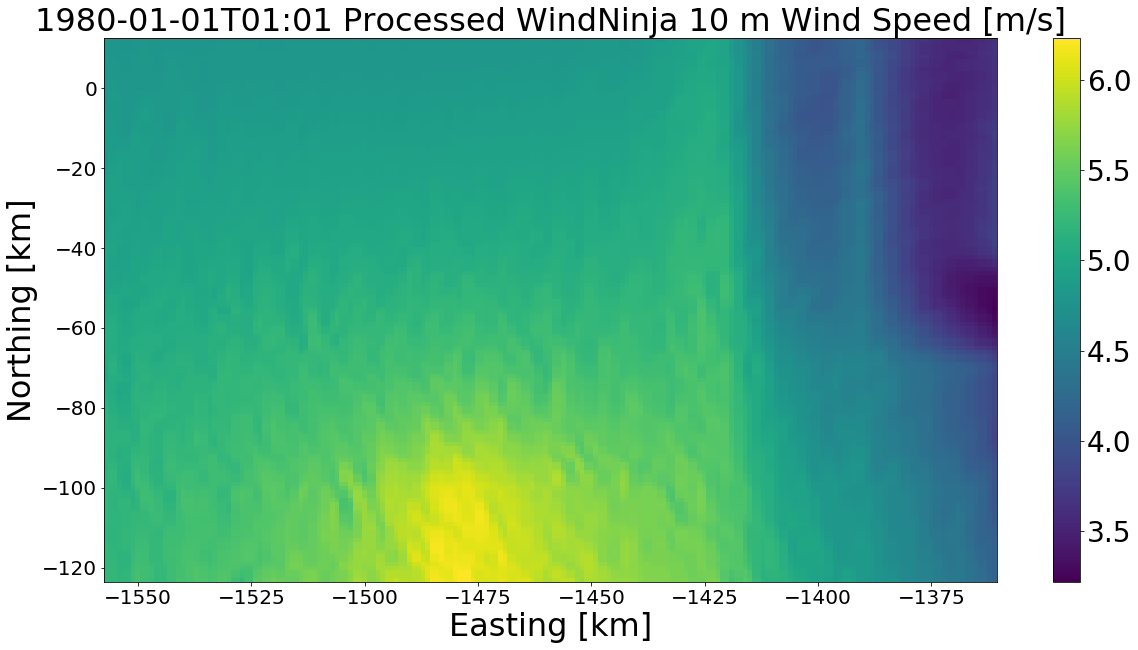

In [9]:
plt.figure(figsize=(20, 10))
plt.pcolor(wn_processed_x, wn_processed_y, wn_processed, vmin=minima, vmax=maxima)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=28)
plt.xlim([wn_processed_x.min(), wn_processed_x.max()])
plt.ylim([wn_processed_y.min(), wn_processed_y.max()])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Easting [km]", fontsize=32)
plt.ylabel("Northing [km]", fontsize=32)
plt.title(time_str + " Processed WindNinja 10 m Wind Speed [m/s]", fontsize=32)
plt.savefig("figures/Processed_WN_wind_speed.pdf", dpi=100)
plt.savefig("figures/Processed_WN_wind_speed.png", dpi=100)

# Save processed WindNinja output to NetCDF

In [10]:
datasets = []
directory = "/scratch/summit/erke2265/antarctic-windninja/PIG/processed_output/"
for filename in os.listdir(directory):
    if filename.endswith("VW.asc"):
        time_str = filename[0:10]
        date_time = pd.date_range(datetime.datetime.strptime(time_str, "%Y%m%d%H"), periods=1)
        path = directory + filename
        wn_processed = np.flipud(np.loadtxt(path, skiprows=6))
        ds = xr.Dataset(
            {
                "Wind Speed": (["northing", "easting"], wn_processed)
            },
            coords={
                "easting": (["easting"], wn_processed_x),
                "northing": (["northing"], wn_processed_y),
                "time": (["time"], date_time)
            }
        )
        
        datasets.append(ds)
wn = xr.concat(datasets, dim='time')
wn = wn.sortby("time", ascending=True)

In [11]:
wn

<xarray.Dataset>
Dimensions:     (easting: 198, northing: 137, time: 8)
Coordinates:
  * easting     (easting) float64 -1.558e+03 -1.556e+03 ... -1.362e+03 -1.36e+03
  * northing    (northing) float64 -123.5 -122.5 -121.5 ... 10.5 11.5 12.5
  * time        (time) datetime64[ns] 1980-01-01T01:00:00 ... 1980-01-01T08:00:00
Data variables:
    Wind Speed  (time, northing, easting) float64 5.22 5.21 5.21 ... 4.51 4.52

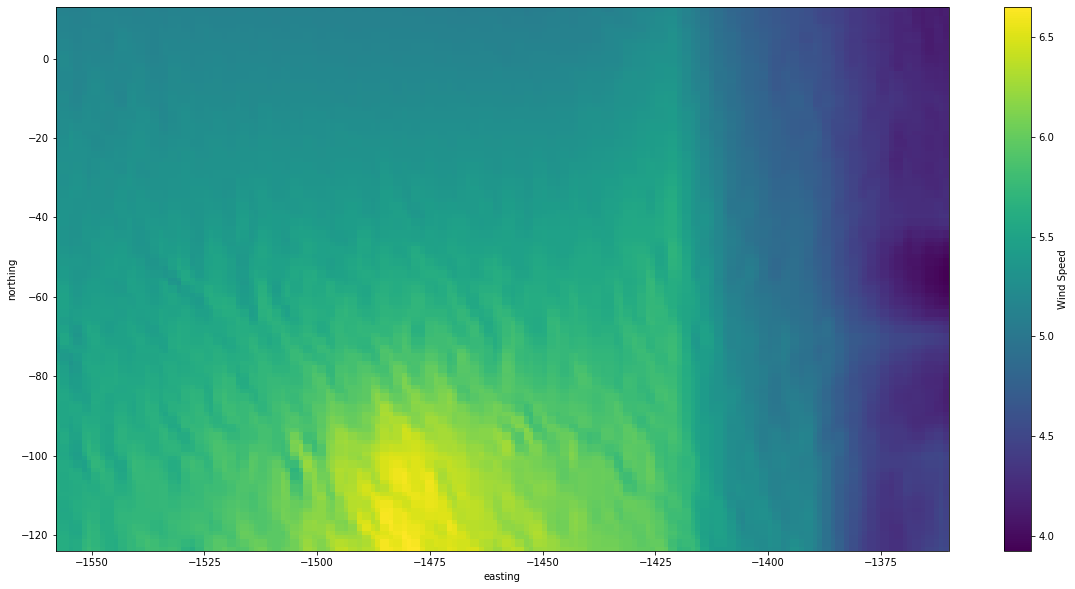

In [12]:
time_mean = wn['Wind Speed'].mean(dim='time')
plt.figure(figsize=(20, 10))
time_mean.plot()